# sup5A

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


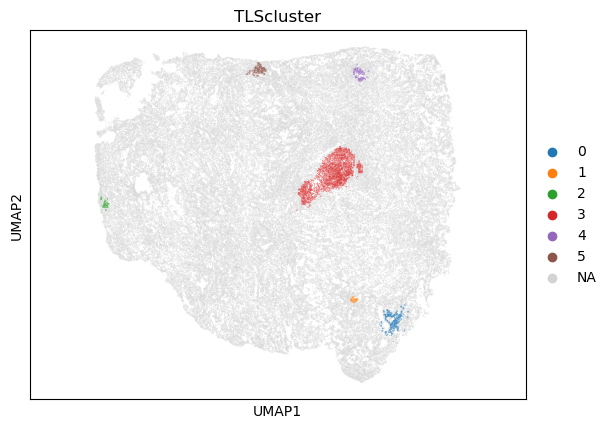

Processing TLScluster 0...


/tmp/ipykernel_1955470/566951529.py:41: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


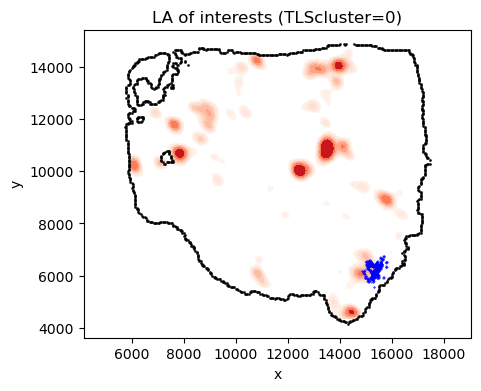

Processing TLScluster 1...


/tmp/ipykernel_1955470/566951529.py:41: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


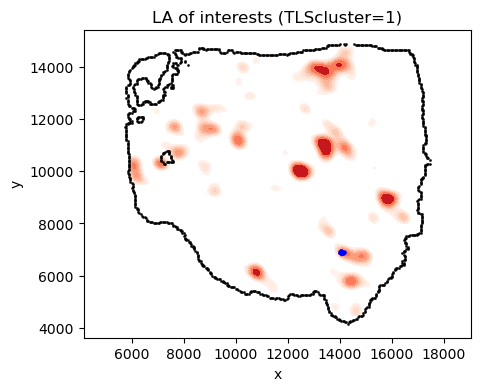

Processing TLScluster 2...


/tmp/ipykernel_1955470/566951529.py:41: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


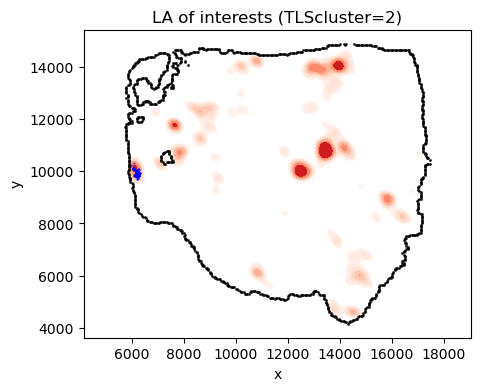

Processing TLScluster 3...


/tmp/ipykernel_1955470/566951529.py:41: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


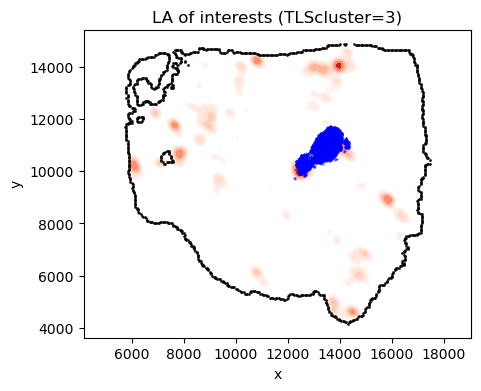

Processing TLScluster 4...


/tmp/ipykernel_1955470/566951529.py:41: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


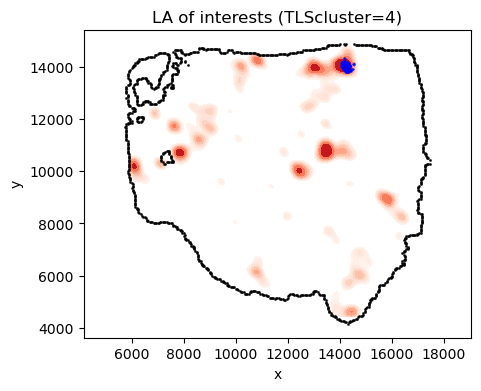

Processing TLScluster 5...


/tmp/ipykernel_1955470/566951529.py:41: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


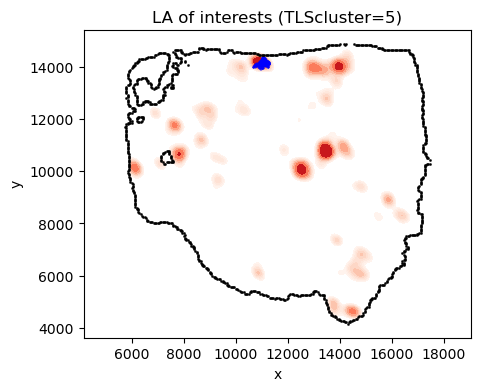

In [4]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data and extract tissue outline ---
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad')
tissue_outline = pd.DataFrame(adata.uns['tissue_outline'], columns=['x', 'y'])

# Set UMAP embedding as the spatial coordinate for quick UMAP plotting (if needed)
adata.obsm['X_umap'] = adata.obsm['spatial']
sc.pl.umap(adata, color='TLScluster', show=False)
plt.axis('equal')
#plt.savefig('D06047A2_TLS.pdf')
plt.show()

# --- For each TLS cluster, show KDE of shared clones ---
for clusNo in adata.obs['TLScluster'].cat.categories.to_list():
    LA = 'LA-TLS'
    clus = 'TLScluster'
    iso = 'IGHcdr3aa'
    print(f"Processing TLScluster {clusNo}...")

    # Only LA-TLS regions
    df = adata.obs[adata.obs['bin50 structural annotation'] == LA]
    # Crosstab: cluster × IGHcdr3aa (counts of clones in each cluster)
    crosstab = pd.crosstab(df[clus], df[iso])
    shared_sequences = crosstab.columns[crosstab.sum(axis=0) > 1]
    shared_stats = crosstab.sum(axis=0)
    num_shared_sequences = len(shared_sequences)
    shared_details = shared_stats[shared_sequences]

    # TLS_XCR: all unique IGHcdr3aa of the current cluster (as "interest" clones)
    TLS_XCR = [x for x in df[df[clus] == clusNo][iso].unique().tolist() if not pd.isna(x)]

    df2 = adata.obs
    plt.figure(figsize=(5, 4))
    plt.title(f'LA of interests (TLScluster={clusNo})')

    # KDE plot for these IGHcdr3aa clones (can highlight shared clonotypes if needed)
    sns.kdeplot(
        data=df2[df2[iso].isin(TLS_XCR)],
        x='x', y='y',
        fill=True, cmap='Reds', bw_adjust=0.2, thresh=0.5,
        kernel='linear', cut=0.2
    )

    # Overlay spatial locations for this TLScluster
    plt.scatter(
        df2[df2[clus] == clusNo]['x'],
        df2[df2[clus] == clusNo]['y'],
        color='blue', s=0.1
    )

    # Draw tissue outline
    sns.scatterplot(
        data=tissue_outline, x='x', y='y',
        color='black', s=3, edgecolor=None
    )

    plt.grid(False)
    plt.axis('equal')
    #plt.savefig(f'/data1/fengyu/methods/zy/Review/for_github/sup5/D06047A2/kdeplot_tls_{clusNo}.png', dpi=900, bbox_inches='tight', transparent=False)
    plt.show()

# sup5B

Source TLS clone sharing stats:
                 mean     median        max        min  num_targets
source_TLS                                                         
0           40.123457  44.444444  66.666667  11.111111            9
1           45.370370  41.666667  75.000000  25.000000            9
2           29.629630  33.333333  55.555556  11.111111            9
3           16.179337  15.789474  28.070175   5.263158            9
4           32.510288  33.333333  59.259259  11.111111            9
5           27.983539  29.629630  44.444444  11.111111            9
6           28.703704  25.000000  50.000000   8.333333            9
7           36.111111  37.500000  56.250000  18.750000            9
8           33.333333  28.571429  64.285714  14.285714            9
9           57.777778  60.000000  80.000000  20.000000            9

First few rows of result table:
   source_TLS  target_TLS     distance  shared_clone_count  \
0           0           1  4951.003103                   

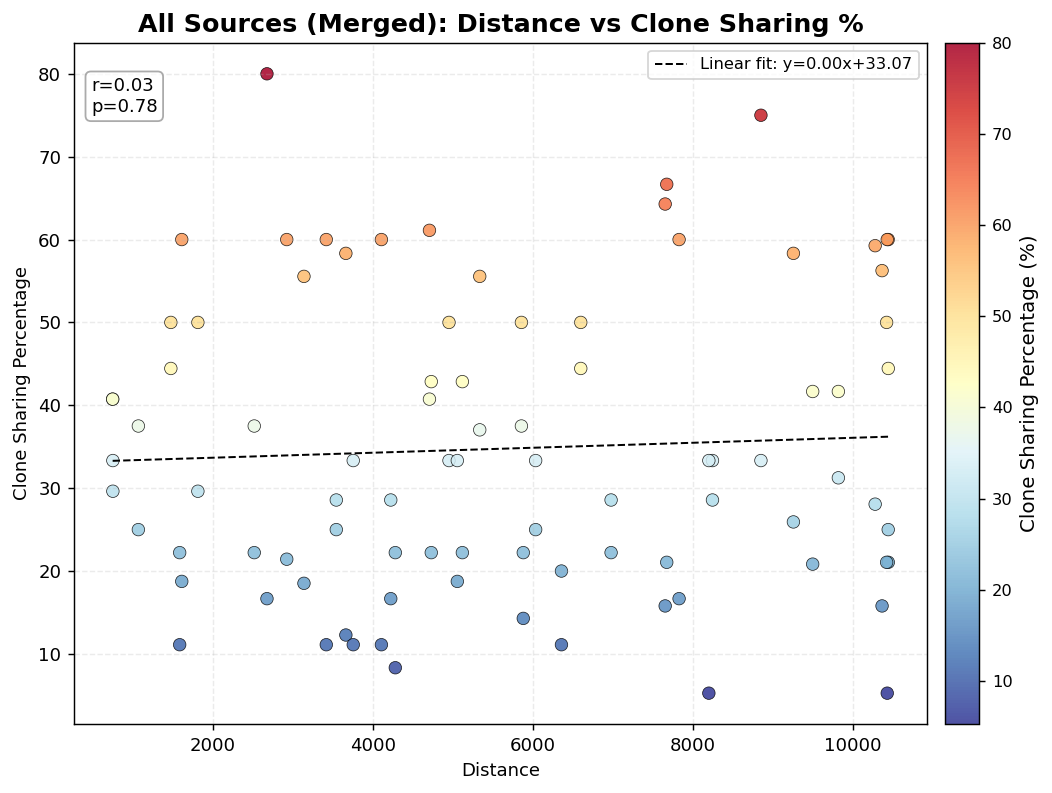


Result columns: ['source_TLS', 'target_TLS', 'distance', 'shared_clone_count', 'source_clone_count', 'clone_sharing_percentage']
Number of rows in result_df: 90


In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from pandas.api.types import is_numeric_dtype

# ======== Configuration ========
POINT_SIZE           = 48
POINT_EDGE_COLOR     = 'black'
POINT_EDGE_WIDTH     = 0.4
POINT_ALPHA          = 0.85
CMAP                 = 'RdYlBu_r'
FIG_DPI              = 130
SHOW_LINEAR_FIT      = True
SHOW_SPEARMAN        = True
GRID_STYLE           = {'alpha': 0.25, 'linestyle': '--'}
STATS_BOX_FACE       = 'white'
STATS_BOX_ALPHA      = 0.7
GLOBAL_VMIN_QUANTILE = None
GLOBAL_VMAX_QUANTILE = None
ADD_SECOND_COMBINED_FIG = False    # For completeness, enables additional merged plot
SOURCE_LIMIT            = None     # Limit to first N TLS if not None

# ======== Data Preparation ========
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
obs = adata.obs.copy()
required_cols = {'TLScluster', 'x', 'y', 'IGHcdr3aa'}
missing = required_cols - set(obs.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

if not is_numeric_dtype(obs['TLScluster']):
    obs['TLScluster'] = pd.Categorical(obs['TLScluster'])

# 1. TLScentroids
tls_centers = (
    obs.groupby('TLScluster')[['x', 'y']]
    .mean()
    .rename(columns={'x': 'center_x', 'y': 'center_y'})
)

# 2. Clonotype sets for each cluster
clone_sets = {
    tls: set(g['IGHcdr3aa'].dropna().unique())
    for tls, g in obs.groupby('TLScluster')
}

all_tls = list(tls_centers.index)
if SOURCE_LIMIT is not None:
    all_tls = all_tls[:SOURCE_LIMIT]

# ======== Long Table: Calc for all source→target pairs ========
records = []
for source in all_tls:
    source_center = tls_centers.loc[source]
    source_clones = clone_sets.get(source, set())
    source_clone_count = len(source_clones)
    for target in tls_centers.index:
        if source == target:
            continue
        target_center = tls_centers.loc[target]
        dist = np.hypot(
            target_center['center_x'] - source_center['center_x'],
            target_center['center_y'] - source_center['center_y']
        )
        target_clones = clone_sets.get(target, set())
        shared = len(source_clones & target_clones)
        sharing_pct = (shared / source_clone_count * 100) if source_clone_count > 0 else np.nan
        records.append({
            'source_TLS': source,
            'target_TLS': target,
            'distance': dist,
            'shared_clone_count': shared,
            'source_clone_count': source_clone_count,
            'clone_sharing_percentage': sharing_pct
        })

result_df = pd.DataFrame(records)

# ======== Summary Stats per Source TLS ========
summary = (
    result_df.groupby('source_TLS')['clone_sharing_percentage']
    .agg(['mean', 'median', 'max', 'min', 'count'])
    .rename(columns={'count': 'num_targets'})
)
print("Source TLS clone sharing stats:")
print(summary)
print("\nFirst few rows of result table:")
print(result_df.head())

# ======== Color scale ========
valid_vals = result_df['clone_sharing_percentage'].dropna()
if GLOBAL_VMIN_QUANTILE is not None:
    vmin = valid_vals.quantile(GLOBAL_VMIN_QUANTILE)
else:
    vmin = valid_vals.min()
if GLOBAL_VMAX_QUANTILE is not None:
    vmax = valid_vals.quantile(GLOBAL_VMAX_QUANTILE)
else:
    vmax = valid_vals.max()
print(f"Colormap range: vmin={vmin:.3f}, vmax={vmax:.3f}")

# ======== Main Plot: All sources, all targets combined ========
plt.figure(figsize=(8.2, 6.2), dpi=FIG_DPI)
combined1 = result_df[result_df['source_TLS'].isin(all_tls)].dropna(subset=['clone_sharing_percentage']).copy()

sc1 = plt.scatter(
    combined1['distance'],
    combined1['clone_sharing_percentage'],
    c=combined1['clone_sharing_percentage'],
    cmap=CMAP,
    vmin=vmin, vmax=vmax,
    s=POINT_SIZE, alpha=POINT_ALPHA,
    edgecolor=POINT_EDGE_COLOR, linewidth=POINT_EDGE_WIDTH
)

if SHOW_LINEAR_FIT and len(combined1) >= 2:
    coeffs = np.polyfit(combined1['distance'], combined1['clone_sharing_percentage'], 1)
    fit_x = np.linspace(combined1['distance'].min(), combined1['distance'].max(), 200)
    fit_y = np.polyval(coeffs, fit_x)
    plt.plot(fit_x, fit_y, color='black', linestyle='--', linewidth=1.1,
             label=f"Linear fit: y={coeffs[0]:.2f}x+{coeffs[1]:.2f}")

if SHOW_SPEARMAN and len(combined1) >= 3:
    spear_r, spear_p = spearmanr(combined1['distance'], combined1['clone_sharing_percentage'])
    plt.text(
        0.02, 0.95,
        f"r={spear_r:.2f}\np={spear_p:.2g}",
        transform=plt.gca().transAxes,
        fontsize=10, va='top', ha='left', color='#000000',
        bbox=dict(boxstyle='round', facecolor=STATS_BOX_FACE,
                  alpha=STATS_BOX_ALPHA, edgecolor='#888888')
    )

plt.xlabel("Distance")
plt.ylabel("Clone Sharing Percentage")
plt.title("All Sources (Merged): Distance vs Clone Sharing %", fontsize=14, fontweight='bold')
plt.grid(**GRID_STYLE)

cbar1 = plt.colorbar(sc1, fraction=0.046, pad=0.02)
cbar1.set_label('Clone Sharing Percentage (%)', fontsize=11)
cbar1.ax.tick_params(labelsize=9)
if SHOW_LINEAR_FIT and len(combined1) >= 2:
    plt.legend(loc='upper right', frameon=True, fontsize=9)
plt.savefig('ref3.8.pdf')
plt.tight_layout()
plt.show()

# ======== Optionally: Additional "all sources" merge panel ========
if ADD_SECOND_COMBINED_FIG:
    plt.figure(figsize=(7.8, 6), dpi=FIG_DPI)
    combined2 = result_df.dropna(subset=['clone_sharing_percentage'])
    sc2 = plt.scatter(
        combined2['distance'],
        combined2['clone_sharing_percentage'],
        c=combined2['clone_sharing_percentage'],
        cmap=CMAP, vmin=vmin, vmax=vmax,
        s=POINT_SIZE * 0.9, alpha=0.7,
        edgecolor=POINT_EDGE_COLOR, linewidth=POINT_EDGE_WIDTH
    )
    plt.xlabel("Distance")
    plt.ylabel("Clone Sharing Percentage")
    plt.grid(**GRID_STYLE)
    cbar2 = plt.colorbar(sc2, fraction=0.04, pad=0.02)
    cbar2.set_label('Clone Sharing Percentage (%)', fontsize=11)
    cbar2.ax.tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

# ======== Save data for further analysis (optional) ========
print("\nResult columns:", list(result_df.columns))
print("Number of rows in result_df:", len(result_df))